# Velocity Verlet
## Theory
- like Euler numerical procedure for solving ODEs but with lower false
- approximating the integral with the finite sum by the Taylor expansion
- the cubic and higher-order terms are ignored
Approximation

$$
x(t+\tau)\approx x(t)+\tau \,v(t)-\frac{\tau ^2}{2m}\nabla\phi(x(t))\\
v(t+\tau)\approx v(t)-\frac{\tau }{2m}\left(\nabla\phi(x(t))+\nabla\phi(x(t+\tau))\right)
$$

### Advantage:
- Reversible integrator 
- symplectic
- Simple integrator not converting 

=> more stable and energy-conserving integrator than Euler

## Algorithm
1. defining parameters
      - number of time steps
      - number of particles
      - number of dimension
2. prepering the time iteration
      - creating positiion, velocity and acceleration container
      - initialization by adding the start configuration
      - 
3. time iteration
      - define iteraration scheme (loop p=t-1)
      - vv approximation
      - writing the output array
4. returning position_matrix, velocity_matrix, acceleration_matrix

    

### Goals

- timing
- testing
    - ZeroDivisionError, NameError and TypeErrorn ValueError, Type,Error, RuntimeError, IOError
    - functionality
    - ??
- visualisation
    - timing
    - stability
    - ??
    



In [1]:
%matplotlib notebook
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import time
%load_ext line_profiler

## VV-Integrator

- optimized version

problem closed system einstellung erfolgt eigt im potential ??

proof ??

was ist wenn ich höhere anfangsgeschwindigkeiten habe oder positionen auserhalb der box ?


In [48]:
@jit
def potential_gradient(p,k=0):
    return k*p

In [49]:
@jit
def vv1(potential_gradient, position_init, velocity_init, mass, T, time_step, boxsize, opensys=True, pbc=True):
    
    """
    The function vv realise the integration scheme of the Velocity-Verlet Algorithm. 
    The numerical procedure for solving ODEs is based on approximating the integral by
    Taylor expansion and ignoring the cubic and higher-order terms.
    
    Arguments:
        potential_gradient (function): computes potential gradient for particle-positions 
        position_init (numpy.ndarray(n, dim)): initial configuration in dim dimensions
        velocity_init (numpy.ndarray(n, dim)): initial velocity in dim dimensions
        mass (numpy.ndarray(n)): mass of each particle
        T (int): total time of integration
        time_step (float): step size for integration 
        opensys (boolean): considering a open system (True) or a box (False)
        pbc (boolean): periodic boundary conditions (True) or not periodic (False)
        
    Returns:
        position_matrix (numpy.ndarray(size, n, dim)): configuraiton trajectory
        velocity_matrix (numpy.ndarray(size, n, dim)): velocity trajectory
        acceleration_matrix (numpy.ndarray(size, n, dim)): acceleration trajectory
       
    """
    
    size = int(T/time_step)        
    n = len(position_init)         
    dim = position_init.shape[-1]  
    m = mass
    p_min, p_max = boxsize[0], boxsize[1]
    position_matrix, velocity_matrix, acceleration_matrix = np.zeros((size, n, dim)), np.zeros((size, n, dim)), np.zeros((size, n, dim))
    position_matrix[0], velocity_matrix[0], acceleration_matrix[0] = position_init, velocity_init, potential_gradient(position_init)
    for t in range(1, size):
        p = position_matrix[t-1]
        v = velocity_matrix[t-1]
        a = acceleration_matrix[t]
        gp = potential_gradient(p)
        p_new = p + time_step*v - (time_step**2)/(2*m)*gp
        if pbc:
            p_new = p_new - (p_new > p_max)*(p_max-p_min)
            p_new = p_new + (p_new < p_min)*(p_max-p_min)
        gp_new = potential_gradient(p_new) 
        v_new = v - time_step/(2*m) * (gp + gp_new)
        a = - gp_new/m                              # useless for algorithm! needed for visualisation?
        position_matrix[t], velocity_matrix[t], acceleration_matrix[t] = p_new, v_new, a
    return position_matrix, velocity_matrix, acceleration_matrix

-5.0


<IPython.core.display.Javascript object>


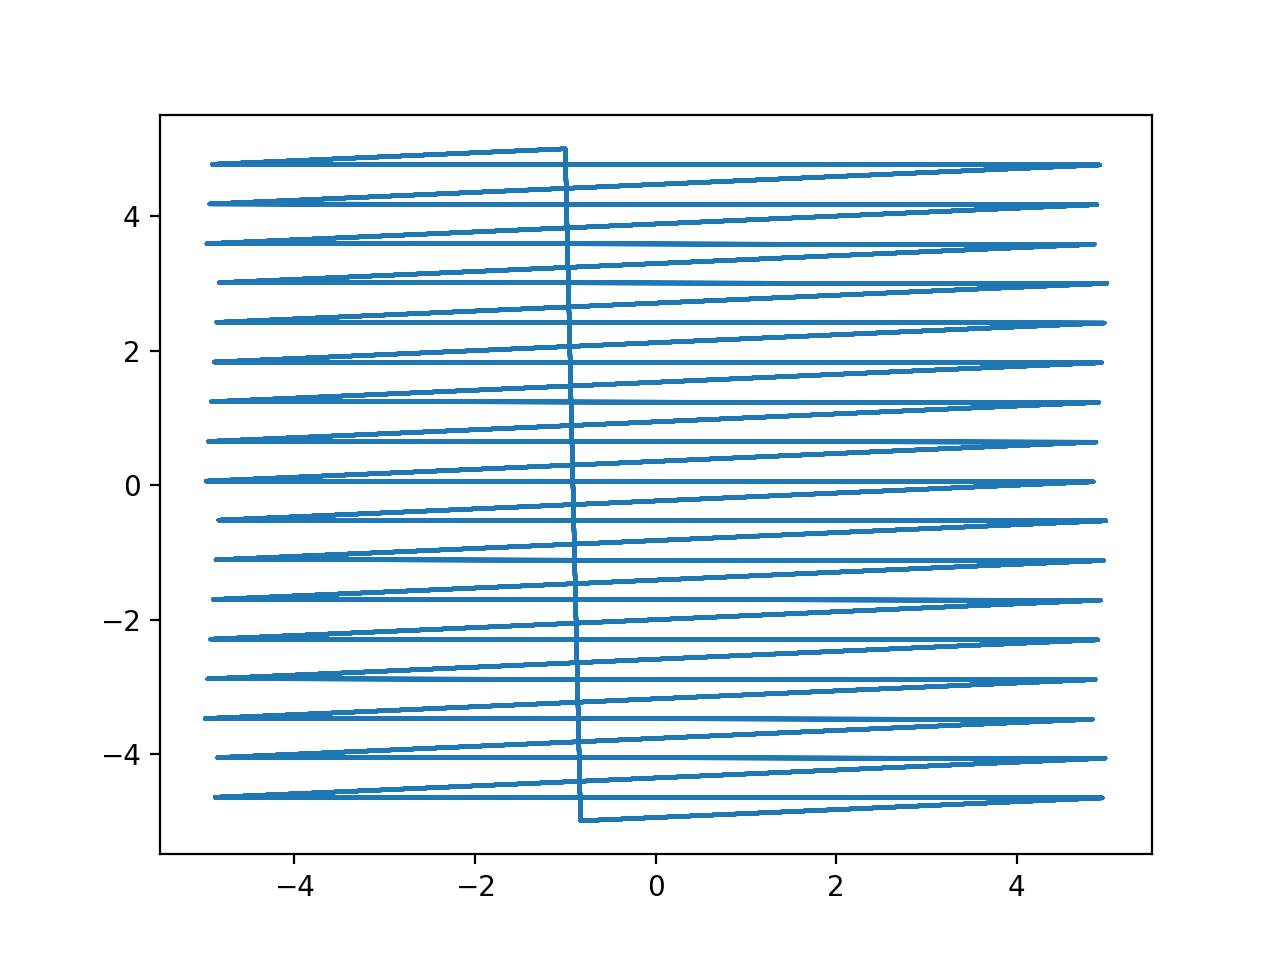

1926666.6666666667

In [59]:
################################### short testing ###########################################
p_max = 95.0
p_min = -95.0
boxsize = (-5., 5.)
print(boxsize[0])

###### input 2D ######
p_0 = np.array([[4., 0.]])
v_0 = np.array([[17., 1.]])
m = np.array([[1., 1.]])

###### input 3D ######
#p_0 = np.array([[5., 0., 0.], [0., 1., 0.]])
#v_0 = np.array([[0., 0., 0.], [0., 0., 0.]])
#m = np.array([[1., 1., 1.], [1., 1., 1.]])

###### energy conservation ######
res = vv1(potential_gradient, p_0, v_0, m, 100, 1/100, boxsize, opensys=True, pbc=True)
#res
#print(a[0][:,0,0])
plt.plot(res[0][:,0, 0], res[0][:,0,1])

##### kinetic energy ######
np.dot(res[1][:,0,0],res[1][:,0,0])*2/3 #???


## timing

#### loop p = t+1
algorithm where p and v needed to calculate the new p and v equals the current timestep
- total run time :  `%timeit`
    - 136 ms ± 3.45 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)
    - 131 ms ± 1.74 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
    - 168 ms ± 19.1 ms per loop (mean ± std. dev. of 100 runs, 10 loops each) (NEW)
    - `@jit`: 140 ms ± 3.01 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
    - `@jit` (NEW):11.2 ms ± 559 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)
    
- line time profiling :  `%lprun`
the most time-consuming step is to calculate the next p and v; 
followed by the calculation of the gp/gp_new and writing of the output arrays
   - `p[t+1] = p[t] + time_step*v[t] - (time_step**2)/(2*m)*g `
        - 28.7 %Time 
        - 29.6 %Time (new)
   - `v[t+1] = v[t] - time_step/(2*m) * (gp + gp_new)`
       - 23.6 %Time
       - 23.7 %Time (New)
    

#### loop p = t-1
algorithm where p and v needed to calculate the new p and v equals the last timestep
- total run time :  `%timeit`
     - 116 ms ± 1.93 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)
     - 113 ms ± 1.54 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
     - 123 ms ± 7.63 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
     - `@jit`: 120 ms ± 9.09 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
     - `@jit`: 119 ms ± 4.25 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)
     - `@jit`(new): 8.38 ms ± 379 µs per loop (mean ± std. dev. of 100 runs, 10 loops each) ???
     - (new): 128 ms ± 5.03 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)

- line time profiling :  `%lprun`
the most time-consuming step is to calculate the next p and v; 
followed by the calculation of the gp/gp_new and riting of the output arrays 
   - `p_new = p + time_step*v - (time_step**2)/(2*m)*gp`
        - 25.7 %Time
        - (new) 26.7%Time 
   - `v_new = v - time_step/(2*m) * (gp + gp_new)`
        - 20.2 %Time
        - (new) 20.7 %Time

on average the loop p=t-1 is 3.8 %Time faster in calculating p_new than p=t+1

### result 
- use loop p = t-1
- numba ? 

In [ ]:
###################################  timing ################################### 
### loop p = t-1 ###
#%lprun -f vv1 vv1(potential_gradient, p_0, v_0, m, 100, 1/100, opensys=True, pbc=False)
#%timeit  -n 10 -r 100 vv1(potential_gradient, p_0, v_0, m, 100, 1/100, opensys=True, pbc=False)

#### loop p = t-1 ###
#%lprun -f vv vv(potential_gradient, p_0, v_0, m, 100, 1/100, opensys=True, pbc=False)
#%timeit -n 10 -r 100 vv(potential_gradient, p_0, v_0, m, 100, 1/100, opensys=True, pbc=False)



## visualisation and interpretation

#### closed system

- how can i implement the box potential ?
- this does not work

In [ ]:
def potential_gradient(p, p_max=np.array([[2.5, 2.5]]), p_min=np.array([[-2.5, -2.5]]), k=1):
    V = k*p
    V_r = 2*np.abs(p*(p>=p_max) - (p_max - p_max/4)*(p>=p_max))**2
    V_l = 2*np.abs(p*(p<=p_min) - (p_max/4)*(p<=p_min))**2
    V = V+ V_r+ V_l 
    #print(V_l)
    #print(V_r)
    #print(V)
    return V  
#p = np.array([[5, 0, 1],[0, 1, 6],[1, 6, 0],[4, 1, 3]])
#pot = potential_gradient(p)
#plt.plot(p[:, 1], pot[:,1])

In [ ]:
def vvclose(potential_gradient, position_init, velocity_init, mass, T, time_step):
    size = int(T/time_step)        # number of time steps
    n = len(position_init)         # number of particles
    dim = position_init.shape[-1]  # number of dimension
    m = mass
    # creating positiion, velocity and acceleration container
    position_matrix, velocity_matrix, acceleration_matrix = np.zeros((size, n, dim)), np.zeros((size, n, dim)), np.zeros((size, n, dim))
    # initialization by adding the start configuration
    position_matrix[0], velocity_matrix[0], acceleration_matrix[0] = position_init, velocity_init, potential_gradient(position_init)
    # time iteration
    for t in range(1, size):
        # rename # kostet das rechenleistung ? bennenung lieber von anfang anders?
        p = position_matrix[t-1]
        v = velocity_matrix[t-1]
        a = acceleration_matrix[t]
        gp = potential_gradient(p)
        # vv approximation
        p_new = p + time_step*v - (time_step**2)/(2*m)*gp
        gp_new = potential_gradient(p_new) 
        v_new = v - time_step/(2*m) * (gp + gp_new)
        a = gp_new
#v_new[:,1][p_new[:,1]<0]*=-1 ???
        # write in pos and vel container
        position_matrix[t], velocity_matrix[t], acceleration_matrix[t] = p_new, v_new, a
    # returning position and velocety container
    return position_matrix, velocity_matrix, acceleration_matrix

In [ ]:
################################### short testing ###########################################
p_max = np.array([[2.5, 2.5]])
p_min = np.array([[-2.5, -2.5]])

###### input 2D ######
p_0 = np.array([[2., 0.]])
v_0 = np.array([[1., 0.]])
m = np.array([[1., 1.]])

###### input 3D ######
#p_0 = np.array([[5., 0., 0.], [0., 1., 0.]])
#v_0 = np.array([[0., 0., 0.], [0., 0., 0.]])
#m = np.array([[1., 1., 1.], [1., 1., 1.]])

###### timing ######
#%lprun -f vvclose vvclose(potential_gradient, p_0, v_0, m, 100, 1/100)  #?

###### visualisation ######
res = vvclose(potential_gradient, p_0, v_0, m, 100, 1/100)
#res
plt.plot(res[0][:,0, 0], res[1][:,0,0])

## full VV- algorithim
- loop p = t+1
- but not so fast

In [ ]:
@jit
def vv(potential_gradient, position_init, velocity_init, mass, T, time_step, opensys=True, pbc=True):
    
    """
    The function vv realise the integration scheme of the Velocity-Verlet Algorithm. 
    The numerical procedure for solving ODEs is based on approximating the integral by
    Taylor expansion and ignoring the cubic and higher-order terms.
    
    Arguments:
        potential_gradient (function): computes potential gradient for particle-positions 
        position_init (numpy.ndarray(n, dim)): initial configuration in dim dimensions
        velocity_init (numpy.ndarray(n, dim)): initial velocity in dim dimensions
        mass (numpy.ndarray(n)): mass of each particle
        T (int): total time of integration
        time_step (int): step size for integration 
        opensys (boolean): considering a open system (True) or a box (False)
        pbc (boolean): periodic boundary conditions (True) or not periodic (False)
        
    Returns:
        position_matrix (numpy.ndarray(size, n, dim)): configuraiton trajectory
        velocity_matrix (numpy.ndarray(size, n, dim)): velocity trajectory
        acceleration_matrix (numpy.ndarray(size, n, dim)): acceleration trajectory
       
    """
    
    size = int(T/time_step)        
    n = len(position_init)         
    dim = position_init.shape[-1]  
    m = mass
    position_matrix, velocity_matrix, acceleration_matrix = np.zeros((size+1, n, dim)), np.zeros((size+1, n, dim)), np.zeros((size+1, n, dim))
    p = position_matrix
    v = velocity_matrix
    a = acceleration_matrix
    p[0], v[0], a[0] = position_init, velocity_init, potential_gradient(position_init)
    for t in range(size):
        gp = potential_gradient(p[t])
        p[t+1] = p[t] + time_step*v[t] - (time_step**2)/(2*m)*gp
        if pbc == True:
            p[t+1] = p[t+1] - (p[t+1] >= p_max)*p_max
            p[t+1] = p[t+1] + (p[t+1] <= p_min)*p_min
        gp_new = potential_gradient(p[t+1]) 
        v[t+1] = v[t] - time_step/(2*m) * (gp + gp_new)
        a[t] = - gp_new/m                              # useless for algorithm! needed for visualisation?
        position_matrix[t], velocity_matrix[t], acceleration_matrix[t] = p[t+1], v[t+1], a[t]
    return position_matrix, velocity_matrix, acceleration_matrix